In [226]:
# INPUTS

year_ = 1          # 1=first year; 2=second year
speed = 0          # 0=low-speed; 1=high-speed
state = 'Heating'  # Cooling; Heating

In [227]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## NZERTF Operations Summary:

|              |                              | |               |                                |
|:-------------|:-----------------------------|-|:------------- |:-------------------------------|
| First year:  |                              | | Second year:  |                                |
|              | -July 2013 - June 2014       | |               | -Feb 2015 - Jan 2016           |
|              | -standard duct HP system,    | |               | -standard duct HP system,      |
|              |  dehumidification enabled    | |               |  dehumidification disabled     |
|              | -no whole house dehumidifier | |               | -whole house dehumidifier used |
|              | -HRV always on               | |               | -HRV on 45 min out of the hour |

---

### The input file analyzed below was created by:
1. Reading data files from "\\\elshares.el.nist.gov\netzero\HeatPump2013\2014_HP_Files\Processed TXT Datafiles" that fit the pattern "Processed_HeatPumpYYMMDD.txt"
2. Using data channels:

|                              |                                |
|:-----------------------------|:-------------------------------|
| Date and Time                | TOTAL_Capacity_Btu/h           |
| 1514_ODAirTemp#1             | Sensible_Capacity_Btu/h        |
| 1515_ODAirTemp#2             | 1420_IDUnit_Fan&Controls_W     |
| 1610_ReturnAirTemp1          | 1421_IDUnit_PowerDemand_W      |
| 1613_ReturnAirTemp2          | 1422_ODUnit_PowerDemand_W      |
| 1615_ReturnAirTemp3          | HeatPump_Total_Power_W         |
| 1407_Vaisala_IDDewpoint      | Cooling_COP                    |
| Vaisala_ReturnAir_RH%        | 1303_ODComp_Status             |
| ID_Airflow_CFM_ft3/min       | 1302_ID_RevValve_Status        |
| 1802_Refrig_Massflow_lbm/min | 1301_ID_Dehumidify_Status      |

2. Converting to SI units
3. Averaging: 1610_ReturnAirTemp1, 1613_ReturnAirTemp2, and 1615_ReturnAirTemp3
4. Averaging: 1514_ODAirTemp#1 and 1515_ODAirTemp#2
5. Adding a column for compressor speed, where high speed (1) is when ID_Airflow_CFM_ft3/min is greater than 750 CFM (per Vance), and low speed (0) otherwise
6. Adding a column for indoor wet bulb temperature using relations from:
    1. *Humidity Conversion Formulas - Calculation formulas for humidity*. Vaisala, 2013. B210973EN-F.
    2. *Wet-Bulb Temperature from Relative Humidity and Air Temperature*. Stull, W., 2011. American Meteorological Soc.
7. Filtering out values when 'TOTAL_Capacity_Btu/h' is equal to zero
8. Resampling the 3-10 second internal values, averaging them into five-minute intervals
9. Filtering out values when the compressor speed and status are (individually) between 0 (low) and 1 (high) to exclude transition periods


**Notes:**
1. Resistance heat appears to be when '1421_IDUnit_PowerDemand_W' ('IDUnit_PwrDmdHgrMtr_W') > 8000 (range is about 8000 to 11000)

---

## The following characteristic performance curves are needed:
* Total cooling/heating capacity (C) as a function of the wet bulb temperature (Twb) or dry bulb temperature (Tdb) (x) entering the indoor cooling/heating coil, respectively, and Tdb (y) entering the outdoor coil:
$$C = C1 + C2*x + C3*x^2 + C4*y + C5*y^2 + C6*x*y$$
&nbsp;
* Total capacity (C) as a function of the air flow fraction (x) across the indoor coil (-> quadratic also valid):
$$C = C1 + C2*x + C3*x^2 + C4*x^3$$
&nbsp;
* Energy Input Ratio (EIR) as a function of Twb/Tdb (x) entering the cooling/heating cool and Tdb (y) entering the outdoor coil
$$EIR = C1 + C2*x + C3*x^2 + C4*y + C5*y^2 + C6*x*y$$
&nbsp;
* Energy Input Ratio (EIR) as a function of the air flow fraction (x) across the indoor coil (-> cubic also valid)
$$EIR = C1 + C2*x + C3*x^2$$
&nbsp;
* Part load electrical power fraction (PLF) as a function of the part load ratio (x) (sensible cooling/sensible cooling capacity) (-> quadratic also valid)
$$PLF = C1 + C2*x + C3*x^2 + C4*x^3$$
&nbsp;
* Defrost Energy Input Ratio as a function of Twb (x) entering the indoor cool and Tdb (y) entering the outdoor coil
$$DE = C1 + C2*x + C3*x^2 + C4*y + C5*y^2 + C6*x*y$$


## For the following modes:
* Low-speed Cooling
* High-speed Cooling
* Low-speed Heating
* High-speed Heating

## Excluding during:
* Defrosting (except for last curve)
* Dedicated dehumidification
* Supplemental resistance heating

In [228]:
# Import data file and view first few rows

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

if year_ == 1:
    input_file = './HVAC_2013-07_to_2014-06.csv'
elif year_ == 2:
    input_file = './HVAC_2015-02_to_2016_01.csv'
if speed == 0:
    spd_str = "Low-Speed"
elif speed == 1:
    spd_str = "High-Speed"
    
df = pd.read_csv(input_file)
#df = pd.read_csv('C:/Users/mboyd/Desktop/HVAC/HVAC_output.csv')
df.index = pd.to_datetime(df.pop('Timestamp'))
df.head()

,Tdb_OD,Tdb_ID,Tdp_ID,Twb_ID,RH_ID,Vel_ID_m3s,StdVel_ID_m3s,Refrig_kg_min,Cap_Total_W,Sens_Cap_W,IDUnit_PwrDmdLwrMtr_W,IDUnit_PwrDmdHgrMtr_W,ODUnit_PwrDmd_W,HP_PwrTot_W,COP_Cooling,Comp_Status,RevValve_Status,Dehumid_Status,Comp_Spd
Timestamp,,,,,,,,,,,,,,,,,,,
2013-07-01 00:05:00,23.435896,4.815105,14.257526,14.423964,56.840990,0.283267,0.294458,-1.743130,5650.167141,3893.765401,136.128546,138.425050,923.676120,1062.101170,5.320615,0.0,0.0,0.000000,0.0
2013-07-01 00:10:00,23.595349,4.838571,13.933272,13.924947,55.092355,0.293448,0.305016,-1.755548,5919.182399,4196.954343,144.710392,148.044325,939.150968,1087.195293,5.445437,0.0,0.0,0.000000,0.0
2013-07-01 00:15:00,23.445002,4.804582,13.647210,13.520731,54.206384,0.296625,0.308356,-1.763608,5924.758859,4277.885249,148.470780,154.930600,959.645000,1114.575600,5.315946,0.0,0.0,0.000000,0.0
2013-07-01 00:40:00,23.252405,4.444837,14.857074,15.679163,63.119025,0.269391,0.280393,-2.002027,4047.419151,3129.151001,144.860569,147.833578,1434.228031,1582.061610,2.549316,0.0,0.0,0.980392,0.0
2013-07-01 00:45:00,23.630082,4.693869,14.148833,14.320705,57.333595,0.267873,0.278579,-2.200686,5609.988389,3525.531971,140.002538,139.491925,1408.506352,1547.998277,3.596730,0.0,0.0,1.000000,0.0


## Energy Input Ratio (EIR)
* inverse of COP   ($COP^{-1}$)
    * COP = Q/W
    * 'COP_Cooling' includes the total power for everything in the denominator (W)
* however, the COP in this context should not include the fan power or its heating effect, and therefore equal:
    * outdoor unit fan + compressor + misc. powers (e.g., controls) **- fan heating**
* 'ODUnit_PwrDmd_W' will have everything except the indoor misc. powers
* The indoor misc. powers are aoubt 10-12 W (per Vance, and consistent with my observations)
* The fan heating correction is **_added_** to the capacity, to increase the [positive] cooling capacity and decrease the [negative] heating capacity
* The fan heating is approximated using the equation in AHRI Standard 210/240-2008, section 3.7c on page 79:
    > $\frac{1250\ Btu/h}{1000\ scfm} \cdot \bar{\dot{V}} \cdot
    \left(\frac{1\ W}{3.412142\ Btu/h}\right) \cdot
    \left(\frac{2118.88\ scfm}{1\ m^3/s}\right)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 
    , where $\bar{\dot{V}}$ is the supply fan velocity
* Invert the COP to get EIR

In [229]:
df['EIR'] = (abs(df.Cap_Total_W + (1250/1000)*df.Vel_ID_m3s*(1/3.412142)*(2118.88/1)) /
            (df.ODUnit_PwrDmd_W + 11))**-1

Filtering out 2.7% of EIR values


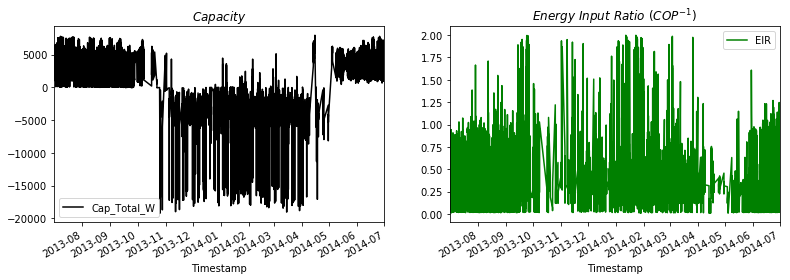

In [230]:
# Run plots

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

# Total Capacity
df.plot(y="Cap_Total_W", color="Black", title=r'$Capacity$', ax=axes[0])

# Energy Input Ratio (COP^-1)
# Filter out anything above 2 and below 0
EIR_limit = 2
EIR_in_bounds = (df.EIR < EIR_limit) & (df.EIR > 0)
df[EIR_in_bounds].plot(y="EIR", color="Green", title=r'$Energy\ Input\ Ratio\ (COP^{-1})$', ax=axes[1])

perc_filtered = (1 - sum(EIR_in_bounds) / df.shape[0]) * 100
print('Filtering out {0:.1f}% of EIR values'.format(perc_filtered))

# df_cl = df[cool_spd]
# df_cl['20140701':'20140706'].plot.line(y=['ODUnit_PwrDmd_W', 'Vel_ID_m3s'], title='OD Power and CFM',
#                                        figsize=(15,5), color=['Black', 'Purple'],
#                                        secondary_y=('Vel_ID_m3s'), mark_right=True, rot=45)

### -> The capacity is negative while heating and positive while cooling, verified by Vance

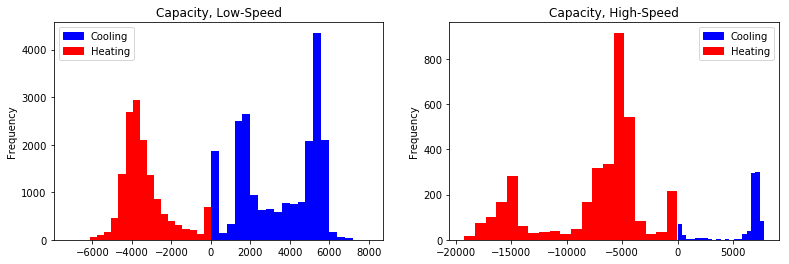

In [231]:
# Plot the histograms of the capacity at low and high speeds

def capacity_hist(speed, title_, pos):
    cool_spd = (df.Cap_Total_W > 0) & (df.Comp_Spd == speed)
    heat_spd = (df.Cap_Total_W < 0) & (df.Comp_Spd == speed)
    df.loc[cool_spd, 'Cap_Total_W'].plot.hist(bins=20, title=title_, color ='Blue', ax=pos)
    df.loc[heat_spd, 'Cap_Total_W'].plot.hist(bins=20, color='Red', ax=pos)
    blue_patch = mpatches.Patch(color='Blue', label='Cooling')
    red_patch = mpatches.Patch(color='Red', label='Heating')
    pos.legend(handles=[blue_patch, red_patch])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
capacity_hist(speed=0, title_='Capacity, Low-Speed', pos=axes[0])
capacity_hist(speed=1, title_='Capacity, High-Speed', pos=axes[1])

### -> In year 1, there appears to be two operating modes when cooling at low speed and when heating at high speed -> the less frequent cooling mode was found to be dedicated dehumidification

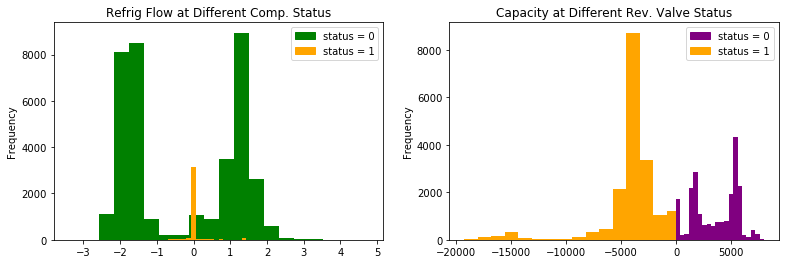

In [232]:
# Relate compressor status to refrigerant flow and reversing valve status to capacity

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

# Compressor Status
stat0 = df.Comp_Status == 0
stat1 = df.Comp_Status == 1
df.loc[stat0, 'Refrig_kg_min'].plot.hist(bins=20,
                                         title='Refrig Flow at Different Comp. Status',
                                         color='Green',
                                         ax=axes[0])
df.loc[stat1, 'Refrig_kg_min'].plot.hist(bins=20, color='Orange', ax=axes[0])
patch1 = mpatches.Patch(color='Green', label='status = 0')
patch2 = mpatches.Patch(color='Orange', label='status = 1')
axes[0].legend(handles=[patch1, patch2])


# Reversing Valve
stat0 = df.RevValve_Status == 0
stat1 = df.RevValve_Status == 1
df.loc[stat1, 'Cap_Total_W'].plot.hist(bins=20, 
                                       title='Capacity at Different Rev. Valve Status',
                                       color='Orange',
                                       ax=axes[1])
df.loc[stat0, 'Cap_Total_W'].plot.hist(bins=20, color='Purple', ax=axes[1])
patch2 = mpatches.Patch(color='Orange', label='status = 1')
patch1 = mpatches.Patch(color='Purple', label='status = 0')
axes[1].legend(handles=[patch1, patch2])

### -> Compressor is off when respective status = 1
### -> Reversing Valve is rejecting heat to outdoor coil when respective status = 0 &nbsp; &nbsp; &nbsp; (capacity is + when cooling)

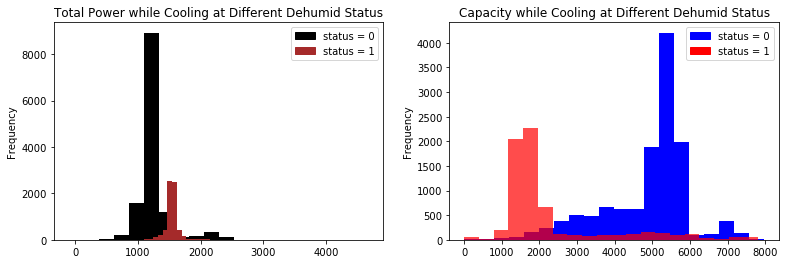

In [233]:
# Relate dehumidification status to outdoor power and capacity while cooling

cool_dehumid0 = (df.Cap_Total_W > 0) & (df.Comp_Status == 0) & (df.Dehumid_Status == 0)
cool_dehumid1 = (df.Cap_Total_W > 0) & (df.Comp_Status == 0) & (df.Dehumid_Status == 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
# Total Power
try:
    df.loc[cool_dehumid0, 'HP_PwrTot_W'].plot.hist(bins=20,
                                                   title='Total Power while Cooling at Different Dehumid Status',
                                                   color='Black',
                                                   ax=axes[0])
except: pass
try:
    df.loc[cool_dehumid1, 'HP_PwrTot_W'].plot.hist(bins=20, color='Brown', ax=axes[0])
except: pass
patch1 = mpatches.Patch(color='Black', label='status = 0')
patch2 = mpatches.Patch(color='Brown', label='status = 1')
axes[0].legend(handles=[patch1, patch2])

# Capacity
try:
    df.loc[cool_dehumid0, 'Cap_Total_W'].plot.hist(bins=20,
                                                   title='Capacity while Cooling at Different Dehumid Status',
                                                   color='Blue',
                                                   ax=axes[1])
except: pass
try:
    df.loc[cool_dehumid1, 'Cap_Total_W'].plot.hist(bins=20, color='Red', alpha=0.7, ax=axes[1])
except: pass
patch1 = mpatches.Patch(color='Blue', label='status = 0')
patch2 = mpatches.Patch(color='Red', label='status = 1')
axes[1].legend(handles=[patch1, patch2])

### -> Dehumidifying when respective status = 1

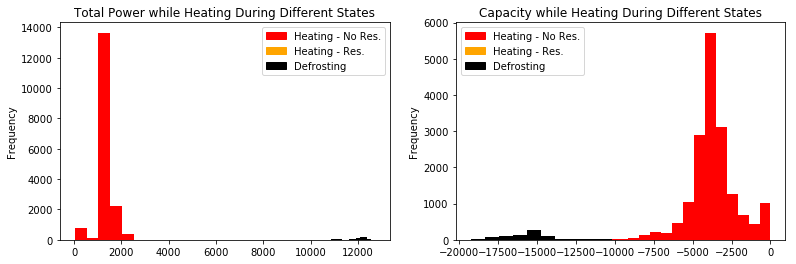

In [234]:
# Relate defrost and resistance heating to outdoor power and capacity while heating

res_heating = (df.Cap_Total_W < 0) & (df.IDUnit_PwrDmdHgrMtr_W > 8000) & (df.RevValve_Status == 0)
defrosting = (df.Cap_Total_W < 0) & (df.IDUnit_PwrDmdHgrMtr_W > 8000) & (df.RevValve_Status == 1)
no_res_no_defrost = (df.Cap_Total_W < 0) & ~res_heating & ~defrosting

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

# Total Power
try:
    df.loc[no_res_no_defrost, 'HP_PwrTot_W'].plot.hist(bins=20,
                                                       title='Total Power while Heating During Different States',
                                                       color='Red',
                                                       ax=axes[0])
except: pass
try:
    df.loc[res_heating, 'HP_PwrTot_W'].plot.hist(bins=20, color='Orange', ax=axes[0])
except: pass
try:
    df.loc[defrosting, 'HP_PwrTot_W'].plot.hist(bins=20, color='Black', ax=axes[0])
except: pass
patch1 = mpatches.Patch(color='Red', label='Heating - No Res.')
patch2 = mpatches.Patch(color='Orange', label='Heating - Res.')
patch3 = mpatches.Patch(color='Black', label='Defrosting')
axes[0].legend(handles=[patch1, patch2, patch3])

# Capacity
try:
    df.loc[no_res_no_defrost, 'Cap_Total_W'].plot.hist(bins=20,
                                                       title='Capacity while Heating During Different States',
                                                       color='Red',
                                                       ax=axes[1])
except: pass
try:
    df.loc[res_heating, 'Cap_Total_W'].plot.hist(bins=20, color='Orange', ax=axes[1])
except: pass
try:
    df.loc[defrosting, 'Cap_Total_W'].plot.hist(bins=20, color='Black', ax=axes[1])
except: pass
patch1 = mpatches.Patch(color='Red', label='Heating - No Res.')
patch2 = mpatches.Patch(color='Orange', label='Heating - Res.')
patch3 = mpatches.Patch(color='Black', label='Defrosting')
axes[1].legend(handles=[patch1, patch2, patch3])

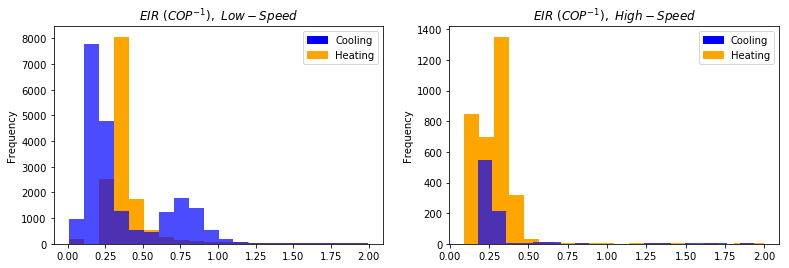

In [235]:
# Plot histograms of the Energy Input Ratio (inverse of COP) at low and high speeds

def EIR_hist(speed, title_, pos):
    cool_spd = (df.Cap_Total_W > 0) & (df.Comp_Spd == speed) & EIR_in_bounds
    heat_spd = (df.Cap_Total_W < 0) & (df.Comp_Spd == speed) & EIR_in_bounds
    df.loc[heat_spd, 'EIR'].plot.hist(bins=20, color='Orange', ax=pos)
    df.loc[cool_spd, 'EIR'].plot.hist(bins=20, title=title_, color ='Blue', alpha=0.7, ax=pos)
    patch1 = mpatches.Patch(color='Orange', label='Heating')
    patch2 = mpatches.Patch(color='Blue', label='Cooling')
    pos.legend(handles=[patch2, patch1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
EIR_hist(speed=0, title_=r'$EIR\ (COP^{-1}),\ Low-Speed$', pos=axes[0])
EIR_hist(speed=1, title_=r'$EIR\ (COP^{-1}),\ High-Speed$', pos=axes[1])

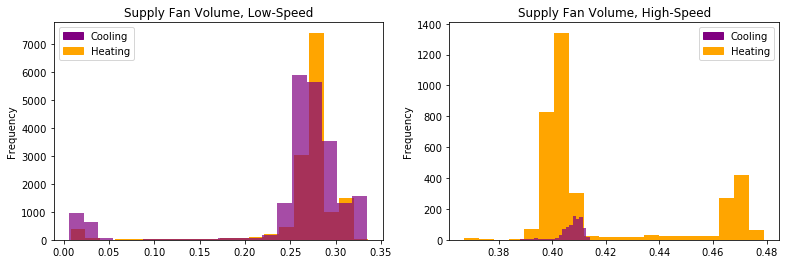

In [236]:
# Plot histograms of the supply fan volume at low and high speeds

def SFV_hist(speed, title_, pos):
    cool_spd = (df.Cap_Total_W > 0) & (df.Comp_Spd == speed)
    heat_spd = (df.Cap_Total_W < 0) & (df.Comp_Spd == speed)
    df.loc[heat_spd, 'Vel_ID_m3s'].plot.hist(bins=20, color='Orange', ax=pos)
    df.loc[cool_spd, 'Vel_ID_m3s'].plot.hist(bins=20, title=title_, color ='Purple', alpha=0.7, ax=pos)
    patch1 = mpatches.Patch(color='Orange', label='Heating')
    patch2 = mpatches.Patch(color='Purple', label='Cooling')
    pos.legend(handles=[patch2, patch1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
SFV_hist(speed=0, title_='Supply Fan Volume, Low-Speed', pos=axes[0])
SFV_hist(speed=1, title_='Supply Fan Volume, High-Speed', pos=axes[1])

In [237]:
# Filter out when the compressor is off, when dedicated dehumidifying, and according to EIR filter
num_rows_orig = df.shape[0]
filter_ = (df.Comp_Status == 0) & (df.Dehumid_Status == 0) & EIR_in_bounds
df = df[filter_].copy()
perc_filtered = (1 - sum(filter_)/num_rows_orig) * 100
print("Filtering out {0:.1f}% of the current values.".format(perc_filtered))

Filtering out 26.8% of the current values.


* * *
### Define Polynomial Functions
#### Quadratic:
> $y = C1 + C2*x + C3*x^2$

#### Cubic:
> $y = C1 + C2*x + C3*x^2 + C4*x^3$

#### Biquadratic:
> $z = C1 + C2*x + C3*x^2 + C4*y + C5*y^2 + C6*x*y$

In [238]:
def lin(x, coeffs):
    # function form: y = C1 + C2*x
    # coeffs: (C1, C2)
    
    y = coeffs[0] + coeffs[1]*x
    return y

def quad(x, coeffs):
    # function form: y = C1 + C2*x + C3*x^2
    # coeffs: (C1, C2, C3)
    
    y = coeffs[0] + coeffs[1]*x + coeffs[2]*x**2
    return y

def cubic(x, coeffs):
    # function form: y = C1 + C2*x + C3*x^2 + C4*x^3
    # coeffs: (C1, C2, C3, C4)
    
    y = coeffs[0] + coeffs[1]*x + coeffs[2]*x**2 + coeffs[3]*x**3
    return y

def biquad(x, y, coeffs):
    # function form: z = C1 + C2*x + C3*x^2 + C4*y + C5*y^2 + C6*x*y
    # coeffs: (C1, C2, C3, C4, C5, C6)
    
    z = coeffs[0] + coeffs[1]*x + coeffs[2]*x**2 + coeffs[3]*y + coeffs[4]*y**2 + coeffs[5]*x*y
    return z

### Define Regressions

In [239]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn import metrics

def regr_simple(x, y, deg):
    """quadratic regression of the data"""
    polynomial_features = PolynomialFeatures(degree=deg, include_bias=True)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    pipeline.fit(x, y)
    coeffs = pipeline.named_steps['linear_regression'].coef_                # also in pipeline.steps[1][1].coef_
    intercept = pipeline.named_steps['linear_regression'].intercept_        # also in pipeline.steps[1][1].intercept_
    # powers = pipeline.named_steps['polynomial_features'].powers_
    poly_coeffs = coeffs.ravel()
    poly_coeffs[0] = intercept
    
    # r2 = pipeline.score(x, y)    # appears to give r-squared, but I can't find documentation

    # # Evaluate the models using crossvalidation
    # scores = model_selection.cross_val_score(pipeline, x, y, scoring="r2", cv=10)

    y_pred = pipeline.predict(x)
    stats = {'R-squared' : metrics.r2_score(y, y_pred),
             'MedianAbsErr' : metrics.median_absolute_error(y, y_pred),
             'MeanSqErr' : metrics.mean_squared_error(y, y_pred)}

    return poly_coeffs, stats

def regr_multi(x, y, z, deg):
    """biquadratic regression of the data"""
    polynomial_features = PolynomialFeatures(degree=deg, include_bias=True)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    indepen = np.transpose(np.vstack((x, y)))
    pipeline.fit(indepen, z)
    coeffs = pipeline.named_steps['linear_regression'].coef_                # also in pipeline.steps[1][1].coef_
    intercept = pipeline.named_steps['linear_regression'].intercept_        # also in pipeline.steps[1][1].intercept_
    poly_coeffs = coeffs.ravel()
    poly_coeffs[0] = intercept
    
    # rearrange from: z = C1 + C2*x + C3*y + C4*x^2 + C5*x*y + C6*y^2
    # (see: http://scikit-learn.org/stable/modules/linear_model.html)
    # to: z = C1 + C2*x + C3*x^2 + C4*y + C5*y^2 + C6*x*y
    new_order = [0, 1, 3, 2, 5, 4]
    poly_coeffs = [poly_coeffs[i] for i in new_order]

    z_pred = pipeline.predict(indepen)
    stats = {'R-squared' : metrics.r2_score(z, z_pred),
             'MedianAbsErr' : metrics.median_absolute_error(z, z_pred),
             'MeanSqErr' : metrics.mean_squared_error(z, z_pred)}

    return poly_coeffs, stats

def regr_lin(x, y):
    degree = 1
    poly_coeffs, stats = regr_simple(x, y, degree)
    return poly_coeffs, stats

def regr_quad(x, y):
    degree = 2
    poly_coeffs, stats = regr_simple(x, y, degree)
    return poly_coeffs, stats

def regr_cubic(x, y):
    degree = 3
    poly_coeffs, stats = regr_simple(x, y, degree)
    return poly_coeffs, stats

def regr_biquad(x, y, z):
    degree = 2
    poly_coeffs, stats = regr_multi(x, y, z, degree)
    return poly_coeffs, stats

---
### Total capacity as a function of the Twb/Tdb (x) entering the indoor coil and Tdb (y) entering the outdoor coil:
$$CC = C1 + C2*x + C3*x^2 + C4*y + C5*y^2 + C6*x*y$$

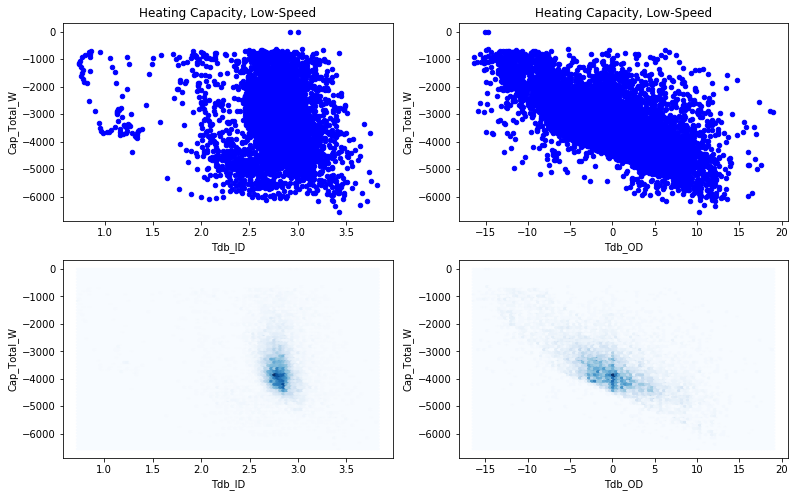

In [240]:
if state == 'Cooling':
    state_spd = (df.Cap_Total_W > 0) & (df.Comp_Spd == speed)
    xname_ = 'Twb_ID'
elif state == 'Heating':
    state_spd = (df.Cap_Total_W < 0) & (df.Comp_Spd == speed)
    xname_ = 'Tdb_ID'
    
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))

# Cap. vs. Txb_ID
df[state_spd].plot.scatter(x=xname_, y='Cap_Total_W', color='Blue', title=state + ' Capacity, ' + spd_str,
                        ax=axes[0,0])
df[state_spd].plot.hexbin(x=xname_, y='Cap_Total_W', colormap='Blues', colorbar=False, ax=axes[1,0])

# Cap. vs. Tdb_OD
df[state_spd].plot.scatter(x='Tdb_OD', y='Cap_Total_W', color='Blue', title=state + ' Capacity, ' + spd_str,
                        ax=axes[0,1])
df[state_spd].plot.hexbin(x='Tdb_OD', y='Cap_Total_W', colormap='Blues', colorbar=False, ax=axes[1,1])

### Normalize Dataset

In [241]:
# Rated values
# <using a negative heating capacity to flip sign in data>
ratings_cool_spd = {'Cooling': {'Low-Speed': {'Cap_Total_W': 6159,
                                              'Vel_ID_m3s': 0.3162,
                                              'COP': 5.641,
                                              'EIR': (1 / 5.641)},
                                'High-Speed': {'Cap_Total_W': 8683,
                                               'Vel_ID_m3s': 0.4177,
                                               'COP': 5.135,
                                               'EIR': (1 / 5.135)}},
                    'Heating': {'Low-Speed': {'Cap_Total_W': -4676,
                                              'Vel_ID_m3s': 0.3162,
                                              'COP': 4.183,
                                              'EIR': (1 / 4.183)},
                                'High-Speed': {'Cap_Total_W': -7382,
                                               'Vel_ID_m3s': 0.4177,
                                               'COP': 4.133,
                                               'EIR': (1 / 4.133)}}}

# Normalize dataset
df_norm_ss = df[state_spd].copy()
df_norm_ss.Cap_Total_W = df_norm_ss.Cap_Total_W / ratings_cool_spd[state][spd_str]['Cap_Total_W']
df_norm_ss.Vel_ID_m3s = df_norm_ss.Vel_ID_m3s / ratings_cool_spd[state][spd_str]['Vel_ID_m3s']
df_norm_ss.COP_Cooling = df_norm_ss.COP_Cooling / ratings_cool_spd[state][spd_str]['COP']
df_norm_ss.EIR = df_norm_ss.EIR / ratings_cool_spd[state][spd_str]['EIR']

### Define Plotting Functions

In [242]:
def plot_lin(df, xname, yname, coeffs, color, title_, legend_, axis_):
    # Evaluate curves using NEW coeffs
    x_input = np.linspace(df[xname].min(), df[xname].max(), num=500)
    y_fx = [lin(x, coeffs) for x in x_input]
    df_mod = pd.DataFrame({xname : x_input,
                           'y_fx' : y_fx})

    # Plot measured data overlaid with new coeff curves
    df.plot.hexbin(x=xname, y=yname, title=title_, colormap=color + 's', colorbar=False, ax=axis_)
    df_mod.plot.line(x=xname, y='y_fx', color='Black', ax=axis_)
    black_patch = mpatches.Patch(color='Black', label=legend_)
    axis_.legend(handles=[black_patch])

def plot_quad(df, xname, yname, coeffs, color, title_, legend_, axis_):
    # Evaluate curves using NEW coeffs
    x_input = np.linspace(df[xname].min(), df[xname].max(), num=500)
    y_fx = [quad(x, coeffs) for x in x_input]
    df_mod = pd.DataFrame({xname : x_input,
                           'y_fx' : y_fx})

    # Plot measured data overlaid with new coeff curves
    df.plot.hexbin(x=xname, y=yname, title=title_, colormap=color + 's', colorbar=False, ax=axis_)
    df_mod.plot.line(x=xname, y='y_fx', color='Black', ax=axis_)
    black_patch = mpatches.Patch(color='Black', label=legend_)
    axis_.legend(handles=[black_patch])

def plot_cubic(df, xname, yname, coeffs, color, title_, legend_, axis_):
    # Evaluate curves using NEW coeffs
    x_input = np.linspace(df[xname].min(), df[xname].max(), num=500)
    y_fx = [cubic(x, coeffs) for x in x_input]
    df_mod = pd.DataFrame({xname : x_input,
                           'y_fx' : y_fx})

    # Plot measured data overlaid with new coeff curves
    df.plot.hexbin(x=xname, y=yname, title=title_, colormap=color + 's', colorbar=False, ax=axis_)
    df_mod.plot.line(x=xname, y='y_fx', color='Black', ax=axis_)
    black_patch = mpatches.Patch(color='Black', label=legend_)
    axis_.legend(handles=[black_patch])

def plot_biquad(df, xname, yname, zname, coeffs, color, title_, legend_):
    # Calculate averages
    x_mean = df.loc[:, xname].mean()
    y_mean = df.loc[:, yname].mean()

    # Evaluate curves using NEW coeffs and constant average values for second dependent variable
    x_input = np.linspace(df[xname].min(), df[xname].max(), num=500)
    y_input = np.linspace(df[yname].min(), df[yname].max(), num=500)
    z_fx = [biquad(x, y, coeffs) for x,y in
            zip(x_input, [y_mean] * len(x_input))]
    z_fy = [biquad(x, y, coeffs) for x,y in
            zip([x_mean] * len(y_input), y_input)]
    df_mod = pd.DataFrame({xname : x_input,
                           yname : y_input,
                           'z_fx' : z_fx,
                           'z_fy' : z_fy})

    # Plot measured data overlaid with new coeff curves
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,4))

    # z vs. x
    df.plot.hexbin(x=xname, y=zname, title=title_, colormap=color + 's', colorbar=False, ax=axes[0])
    df_mod.plot.line(x=xname, y='z_fx', color='Black', ax=axes[0])
    black_patch = mpatches.Patch(color='Black',
                                 label='{0}, {1}={2:.1f}'.format(legend_, yname, y_mean))
    axes[0].legend(handles=[black_patch])

    # z vs. y
    df.plot.hexbin(x=yname, y=zname, title=title_, colormap=color + 's', colorbar=False, ax=axes[1])
    df_mod.plot.line(x=yname, y='z_fy', color='Black', ax=axes[1])
    black_patch = mpatches.Patch(color='Black',
                                 label='{0}, {1}={2:.1f}'.format(legend_, xname, x_mean))
    axes[1].legend(handles=[black_patch])
    

{'R-squared': -15.352940484393269, 'MedianAbsErr': 0.71962298105362776, 'MeanSqErr': 0.57140240173363976}
New Coeffs: [0.74367121430106997, 0.038064538778539853, -0.0056855641542634464, 0.019567044705965785, -0.001072708202115721, 0.0027377860254938885]


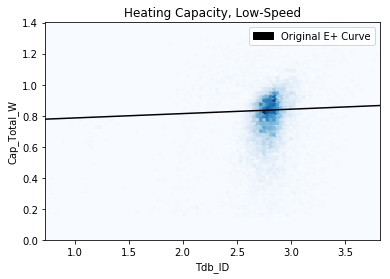

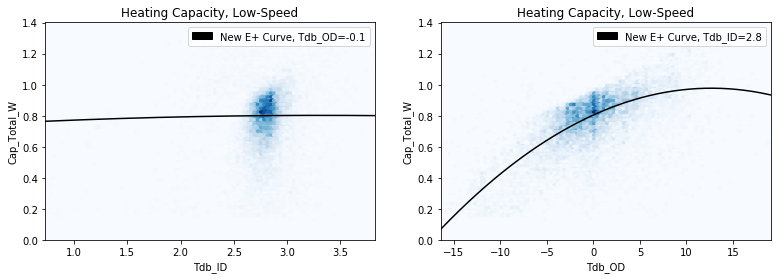

In [243]:
# Plot the normalized Cap. vs Twb and Tdb values and overlay the original performance curve modeled values

# Original coeffs for Cap = Cap(Twb_ID, Tdb_OD)
orig_coeffs = {'Cooling': {'Low-Speed': (0.942587793, 0.009543347, 0.00068377, -0.011042676, 0.000005249,
                                         -0.00000972)},
               'Heating': {'Low-Speed': (0.758746, 0.027626, 0.000148716, 3.4992E-06)}}
orig_coeffs['Cooling']['High-Speed'] = orig_coeffs['Cooling']['Low-Speed']
orig_coeffs['Heating']['High-Speed'] = orig_coeffs['Heating']['Low-Speed']

coeffs_ = orig_coeffs[state][spd_str]
if len(coeffs_) == 6:
    plot_biquad(df_norm_ss, xname=xname_, yname='Tdb_OD', zname='Cap_Total_W', coeffs=coeffs_,
                color='Blue', title_=state + ' Capacity, ' + spd_str, legend_='Original E+ Curve')
elif len(coeffs_) == 4:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    plot_cubic(df_norm_ss, xname=xname_, yname='Cap_Total_W', coeffs=coeffs_,
                color='Blue', title_=state + ' Capacity, ' + spd_str, legend_='Original E+ Curve', axis_=axes)


# Generate a new Capacity vs. Temperature curve and plot

# Create regressions
new_coeffs, stats = regr_biquad(x=df_norm_ss.Twb_ID.as_matrix(),
                                y=df_norm_ss.Tdb_OD.as_matrix(),
                                z=df_norm_ss.Cap_Total_W.as_matrix())
print(stats); print('New Coeffs: {0}'.format(new_coeffs))

# Evaluate curves using NEW coeffs and plot
plot_biquad(df_norm_ss, xname=xname_, yname='Tdb_OD', zname='Cap_Total_W', coeffs=new_coeffs,
            color='Blue', title_=state + ' Capacity, ' + spd_str, legend_='New E+ Curve')

> **_Cooling:_ Correlation should be positive for Twb_ID and negative for Tdb_OD** <br>
> **_Heating:_ Correlation should be negative for Tdb_ID and positive for Tdb_OD**

---
### Total capacity as a function of the air flow fraction (x) across the indoor coil:
$$CC = C1 + C2*x + C3*x^2 + C4*x^3$$

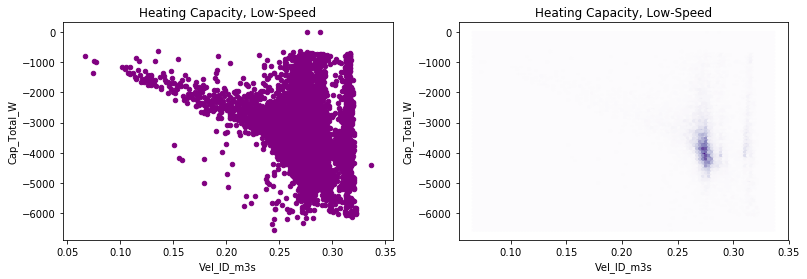

In [244]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
df[state_spd].plot.scatter(x='Vel_ID_m3s', y='Cap_Total_W', color='Purple',
                        title=state + ' Capacity, ' + spd_str, ax=axes[0])
df[state_spd].plot.hexbin(x='Vel_ID_m3s', y='Cap_Total_W', colormap='Purples',
                       title=state + ' Capacity, ' + spd_str, colorbar=False, ax=axes[1])

{'R-squared': -101.27558485728449, 'MedianAbsErr': 1.8521497888252094, 'MeanSqErr': 3.5737006981673303}
New Coeffs: [  1.88200228  -8.84532349  15.25716407  -7.52302848]


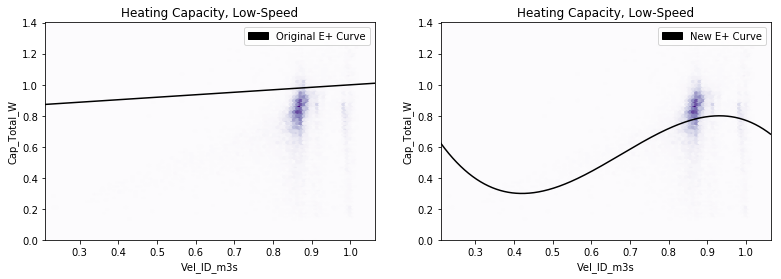

In [245]:
# Plot original and new coeffs for Cap vs. flow
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

# Original
orig_coeffs = {'Cooling': {'Low-Speed': (0.8, 0.2, 0)},
               'Heating': {'Low-Speed': (0.84, 0.16, 0, 0)}}
orig_coeffs['Cooling']['High-Speed'] = orig_coeffs['Cooling']['Low-Speed']
orig_coeffs['Heating']['High-Speed'] = orig_coeffs['Heating']['Low-Speed']

coeffs_ = orig_coeffs[state][spd_str]
if len(coeffs_) == 3:
    plot_quad(df_norm_ss, xname='Vel_ID_m3s', yname='Cap_Total_W', coeffs=coeffs_,
              color='Purple', title_=state + ' Capacity, ' + spd_str, legend_='Original E+ Curve', axis_=axes[0])
elif len(coeffs_) == 4:
    plot_cubic(df_norm_ss, xname='Vel_ID_m3s', yname='Cap_Total_W', coeffs=coeffs_,
               color='Purple', title_=state + ' Capacity, ' + spd_str, legend_='Original E+ Curve', axis_=axes[0])


# New
# Create regressions
new_coeffs, stats = regr_cubic(x=df_norm_ss.Vel_ID_m3s.as_matrix(),
                               y=df_norm_ss.Cap_Total_W.as_matrix())

print(stats); print('New Coeffs: {0}'.format(new_coeffs))
plot_cubic(df_norm_ss, xname='Vel_ID_m3s', yname='Cap_Total_W', coeffs=new_coeffs,
           color='Purple', title_=state + ' Capacity, ' + spd_str, legend_='New E+ Curve', axis_=axes[1])

> **Correlation should be positive**

### Option 2: Linear Fit

{'R-squared': -16.452705877795552, 'MedianAbsErr': 0.7883566112307695, 'MeanSqErr': 0.60983026660193895}
New Coeffs: [-0.75995993  3.08125027 -1.51703862]


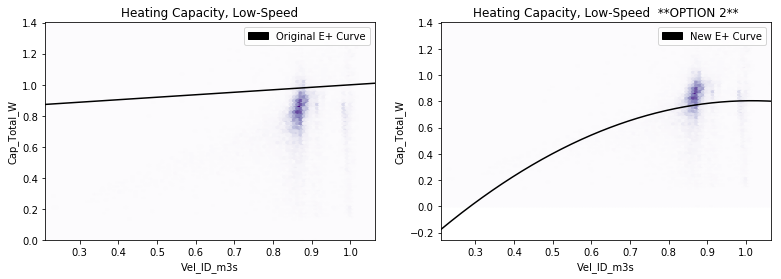

In [246]:
# Option 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

if len(coeffs_) == 3:
    plot_quad(df_norm_ss, xname='Vel_ID_m3s', yname='Cap_Total_W', coeffs=coeffs_,
              color='Purple', title_=state + ' Capacity, ' + spd_str, legend_='Original E+ Curve', axis_=axes[0])
elif len(coeffs_) == 4:
    plot_cubic(df_norm_ss, xname='Vel_ID_m3s', yname='Cap_Total_W', coeffs=coeffs_,
               color='Purple', title_=state + ' Capacity, ' + spd_str, legend_='Original E+ Curve', axis_=axes[0])

new_coeffs, stats = regr_quad(x=df_norm_ss.Vel_ID_m3s.as_matrix(),
                               y=df_norm_ss.Cap_Total_W.as_matrix())

print(stats); print('New Coeffs: {0}'.format(new_coeffs))
plot_quad(df_norm_ss, xname='Vel_ID_m3s', yname='Cap_Total_W', coeffs=new_coeffs,
           color='Purple', title_=state + ' Capacity, ' + spd_str + '  **OPTION 2**', legend_='New E+ Curve', axis_=axes[1])

---
### Energy Input Ratio (EIR) as a function of Twb/Tdb (x) entering the indoor cool and Tdb (y) entering the outdoor coil
$$EIR = C1 + C2*x + C3*x^2 + C4*y + C5*y^2 + C6*x*y$$

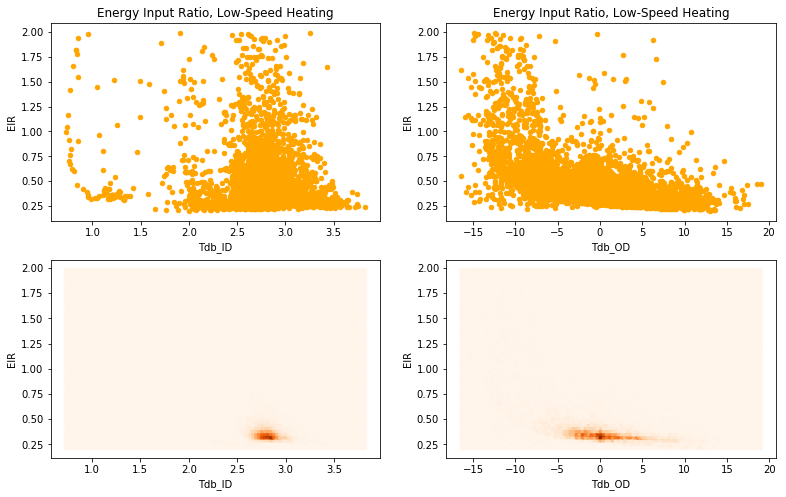

In [247]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))

# EIR vs. Txb_ID
df[state_spd].plot.scatter(x=xname_, y='EIR', color='Orange', title='Energy Input Ratio, ' + spd_str + ' ' + state,
                             ax=axes[0,0])
df[state_spd].plot.hexbin(x=xname_, y='EIR', colormap='Oranges', colorbar=False, ax=axes[1,0])

# EIR vs. Tdb_OD
df[state_spd].plot.scatter(x='Tdb_OD', y='EIR', color='Orange', title='Energy Input Ratio, ' + spd_str + ' ' + state,
                             ax=axes[0,1])
df[state_spd].plot.hexbin(x='Tdb_OD', y='EIR', colormap='Oranges', colorbar=False, ax=axes[1,1])

{'R-squared': -3.6792935489812351, 'MedianAbsErr': 1.5939920584707359, 'MeanSqErr': 2.6845310832055933}
New Coeffs: [1.5299167958305655, -0.050775199296137184, 0.0057997933823055918, -0.078806215250615097, 0.0077467496634697815, 0.0022483506308490866]


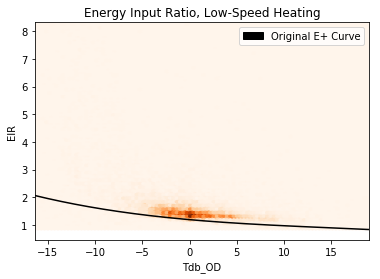

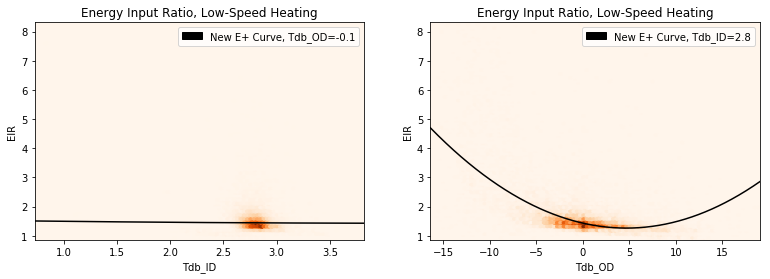

In [248]:
# Plot the normalized EIR vs Twb and Tdb values and overlay the original performance curve modeled values

# Original coeffs for EIR = EIR(Twb_ID, Tdb_OD)
orig_coeffs = {'Cooling': {'Low-Speed': (0.342414409, 0.034885008, -0.0006237, 0.004977216, 0.000437951,
                                         -0.000728028)},
               'Heating': {'Low-Speed': (1.19248, -0.0300438, 0.00103745, -0.000023328)}}
orig_coeffs['Cooling']['High-Speed'] = orig_coeffs['Cooling']['Low-Speed']
orig_coeffs['Heating']['High-Speed'] = orig_coeffs['Heating']['Low-Speed']

coeffs_ = orig_coeffs[state][spd_str]
if len(coeffs_) == 6:
    plot_biquad(df_norm_ss, xname=xname_, yname='Tdb_OD', zname='EIR', coeffs=coeffs_,
                color='Orange', title_='Energy Input Ratio, ' + spd_str + ' ' + state, legend_='Original E+ Curve')
elif len(coeffs_) == 4:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    plot_cubic(df_norm_ss, xname='Tdb_OD', yname='EIR', coeffs=coeffs_,
                color='Orange', title_='Energy Input Ratio, ' + spd_str + ' ' + state, legend_='Original E+ Curve',
                axis_=axes)


# Generate a new Cooling Capacity vs. Temperature curve and plot

# Create regressions
new_coeffs, stats = regr_biquad(x=df_norm_ss.Twb_ID.as_matrix(),
                                y=df_norm_ss.Tdb_OD.as_matrix(),
                                z=df_norm_ss.EIR.as_matrix())
print(stats); print('New Coeffs: {0}'.format(new_coeffs))

# Evaluate curves using NEW coeffs and plot
plot_biquad(df_norm_ss, xname=xname_, yname='Tdb_OD', zname='EIR', coeffs=new_coeffs,
            color='Orange', title_='Energy Input Ratio, ' + spd_str + ' ' + state, legend_='New E+ Curve')

> **_Cooling:_ Correlation should be negative for Twb_ID and positive for Tdb_OD** <br>
> **_Heating:_ Correlation should be positive for Tdb_ID and negative for Tdb_OD**

---
### Energy Input Ratio (EIR) as a function of the air flow fraction (x) across the indoor coil
$$EIR = C1 + C2*x + C3*x^2$$

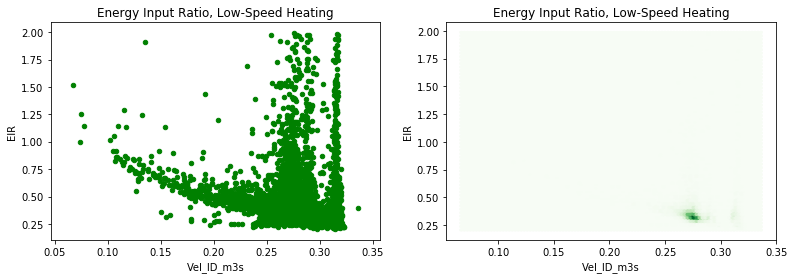

In [249]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
df[state_spd].plot.scatter(x='Vel_ID_m3s', y='EIR', color='Green',
                             title='Energy Input Ratio, ' + spd_str + ' ' + state, ax=axes[0])
df[state_spd].plot.hexbin(x='Vel_ID_m3s', y='EIR', colormap='Greens',
                            title='Energy Input Ratio, ' + spd_str + ' ' + state, colorbar=False, ax=axes[1])

{'R-squared': -16.452705877795552, 'MedianAbsErr': 0.7883566112307695, 'MeanSqErr': 0.60983026660193895}
New Coeffs: [-0.75995993  3.08125027 -1.51703862]


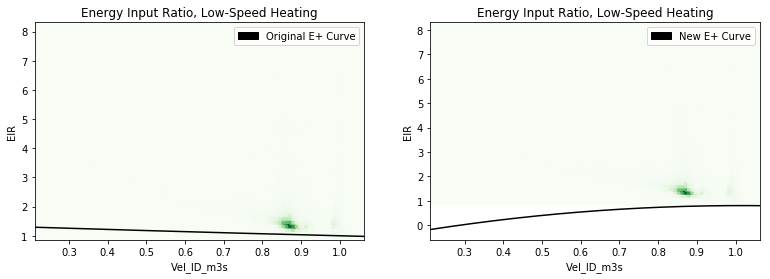

In [250]:
# Plot original and new coeffs for EIR vs. flow
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

# Original
orig_coeffs = {'Cooling': {'Low-Speed': (1.1552, -0.1808, 0.0256)},
               'Heating': {'Low-Speed': (1.3824, -0.4336, 0.0512)}}
orig_coeffs['Cooling']['High-Speed'] = orig_coeffs['Cooling']['Low-Speed']
orig_coeffs['Heating']['High-Speed'] = orig_coeffs['Heating']['Low-Speed']

plot_quad(df_norm_ss, xname='Vel_ID_m3s', yname='EIR', coeffs=orig_coeffs[state][spd_str],
          color='Green', title_='Energy Input Ratio, ' + spd_str + ' ' + state,
          legend_='Original E+ Curve', axis_=axes[0])


# New
# Create regressions
new_coeffs, stats = regr_quad(x=df_norm_ss.Vel_ID_m3s.as_matrix(),
                               y=df_norm_ss.Cap_Total_W.as_matrix())

print(stats); print('New Coeffs: {0}'.format(new_coeffs))
plot_quad(df_norm_ss, xname='Vel_ID_m3s', yname='EIR', coeffs=new_coeffs,
          color='Green', title_='Energy Input Ratio, ' + spd_str + ' ' + state,
          legend_='New E+ Curve', axis_=axes[1])

> **Correlation should be concave up**

## TODO
1. Change plot themes
3. Implement more interactive regression fitting
4. Add electrical power input and steady-state sensible cooling capacity to ratings dict
5. Where is the resistance heating happening?

#### Notes:
* A couple sets of the original curves are spot on, but the rest are a bit off
* The original curves are the default curves with a couple adjusted with the help of Vance